# PV field albedo across the year, from fit with cosine curves

Helpful website:
https://www.suncalc.org/#/29.7692,34.9695,8/2023.03.21/12:21/1/3

Solstice
- Sumer, highest solar elevation: 21 June 12:41 AM (local time = UTC + 3), i.e. 11:41 Israel winter time
- Winter, lowest solar elevation: 22 Dec 11:38 AM (local time = UTC + 2), i.e. 11:38 Israel winter time

Therefore, the 11:30-12:00 measurement period will be used as the maximum solar elevation throughout the year, or more precisely 11:45

In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.optimize import curve_fit
import warnings

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [2]:
# Data location
project_path = './'
data_path = project_path + '../data/'

# Input path
percentage_fn = data_path + 'temperature_by_element.csv'
ketura_fn     = data_path + 'Ketura_all_corr.csv'
yatir_fn      = project_path + '../../data/towerSAS/Yatir_2000-2020.csv'
yotvata_fn    = data_path + 'Yotvata/'
percentage_manual_fn = data_path + 'PV_percentages_manual.csv'

# Output path
graphs_path = project_path + '../graphs/'
output_path = project_path + '../data/'

# Constants
albedo_pv   = 0.05
panel_angle = 30

pv_percent = 51

In [20]:
def load_tower(fn, silent=False):
    if (not silent):
        print('  -', fn.split('/')[-1], '(Note: slow)')
    temp = pd.read_csv(fn, index_col=None)
    temp.rename({'date_mid_hour': 'DateTime'}, axis=1, inplace=True)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%d%b%y:%H:%M')
    # Remove obsolete columns
    temp.drop(['year','date','DOY','month','weekNo','mid_hour','mmyy','Bat_V','Hum_AC'], axis=1, inplace=True)
    return(temp)

def load_truck(fn, index_col=False, silent=False):
    if (not silent):
        print('  -', fn.split('/')[-1])
    temp = pd.read_csv(fn, index_col=index_col)
    temp.rename(columns={'date_time': 'DateTime'}, inplace=True)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S')
    temp['DateTime'] = temp['DateTime'] + pd.Timedelta(minutes=15)
    return(temp)

def load_percentage_lior(fn, silent=False):
    if (not silent): print('  -', fn.split('/')[-1])
    temp = pd.read_csv(fn)
    
    temp.rename(columns={'date_time': 'DateTime'}, inplace=True)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S')
    #temp['DateTime'] = temp['DateTime'] + pd.Timedelta(minutes=15)
    # Move timestamp to front
    col = temp.pop('DateTime')
    temp.insert(0, col.name, col, allow_duplicates=True)
    
    # Remove obsolete columns
    temp.drop(['Unnamed: 0','flight'], axis=1, inplace=True)
    # Change to wide format
    wide = pd.pivot(temp, index='DateTime', columns='label', values='coverage_percent')
    wide.reset_index(inplace=True)
    
    # Normalise the % to 100%, because sometimes it only reaches 96% total
    wide.loc[wide['sun'].isna(), 'sun'] = 0
    wide['total'] = wide['panel'] + wide['shadow'] + wide['soil'] + wide['sun']
    wide['sun']    = wide['sun'] * 100 / wide['total']
    wide['panel']  = wide['panel'] * 100 / wide['total']
    wide['shadow'] = wide['shadow'] * 100 / wide['total']
    wide['soil']   = wide['soil'] * 100 / wide['total']
    wide.drop(['total'], axis=1, inplace=True)
    
    return(wide)

def load_percentage_manual(fn, silent=False):
    if (not silent): print('  -', fn.split('/')[-1])
    temp = pd.read_csv(fn, decimal=',')
    # Organise timestamps
    temp['DateTime'] = temp['filename'].str.slice(4, 17)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%y%m%d_%H%M%S')
    # Adjust to Israel winter time
    temp['DateTime'] = temp['DateTime'] + pd.Timedelta(hours=2)
    # Round to 15min
    temp['DateTime'] = temp['DateTime'].dt.round('15min')
    # Exclude bad data
    temp = temp.loc[(temp['comments'] != 'full shadow, clouds')].copy()
    # Move timestamp to beginning
    col = temp.pop('DateTime')
    temp.insert(0, col.name, col, allow_duplicates=True)
    # Drop timestamp and other unnecessary columns
    temp.drop(['filename','orientation','panels_px','shadow_px','soil_px','total_px'], axis=1, inplace=True)
    # Average by time
    temp = temp.groupby('DateTime').mean()
    temp.reset_index(inplace=True)
    # Rename column
    temp.rename({'panels': 'panel'}, axis=1, inplace=True)
    # Normalise % with panels = 51% (fixed)
    shadow = temp['shadow']
    soil   = temp['soil']
    temp['panel'] = pv_percent
    temp['shadow'] = shadow*(100-pv_percent)/(shadow + soil)
    temp['soil']   = soil*(100-pv_percent)/(shadow + soil)
    return(temp)

def load_meteo_stn(directory, silent=False):
    if (not silent):
        print('  - Meteo station:')
        
    file_list = sorted(glob.glob(directory + '**/*.csv', recursive=True))
    data_list = []
    for idx, filename in enumerate(file_list):
        print('    -', filename.split('/')[-1])
        temp = pd.read_csv(filename)
        data_list.append(temp)
    # Combine all the read data
    df = pd.concat(data_list, axis=0, ignore_index=True)
    # Fix problems
    df.columns = ['station','DateTime', 'Eg_Wm2', 'RH_perc', 'Ta_C', 'u_ms']
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M')
    # Convert to numbers
    df['Eg_Wm2'] = pd.to_numeric(df['Eg_Wm2'], errors='coerce')
    df['RH_perc'] = pd.to_numeric(df['RH_perc'], errors='coerce')
    df['Ta_C'] = pd.to_numeric(df['Ta_C'], errors='coerce')
    df['u_ms'] = pd.to_numeric(df['u_ms'], errors='coerce')
    # Average 10min Yotvata data to half-hours
    df = df.resample('30min', on='DateTime').mean()
    df.reset_index(inplace=True)
    df['DateTime'] = df['DateTime'] + pd.Timedelta(minutes=15)
    return(df)

def add_ecosystem(df):
    df = df.copy()
    # Add ecosystem
    df['Ecosystem'] = np.nan
    df.loc[(df['DateTime'] > '2018-03-17') & (df['DateTime'] < '2018-03-22'), 'Ecosystem'] = 'Desert background'
    df.loc[(df['DateTime'] > '2018-03-21') & (df['DateTime'] < '2018-03-28'), 'Ecosystem'] = 'PV field'
    
    df.loc[(df['DateTime'] > '2018-10-15') & (df['DateTime'] < '2018-10-25'), 'Ecosystem'] = 'Desert background'
    df.loc[(df['DateTime'] > '2018-10-23') & (df['DateTime'] < '2018-11-01'), 'Ecosystem'] = 'PV field'
    
    df.loc[(df['DateTime'] > '2019-07-08') & (df['DateTime'] < '2019-07-17'), 'Ecosystem'] = 'Desert background'
    df.loc[(df['DateTime'] > '2019-07-15') & (df['DateTime'] < '2019-07-25'), 'Ecosystem'] = 'PV field'
    # Season
    df['Season'] = np.nan
    df.loc[(df['DateTime'] > '2018-03-17') & (df['DateTime'] < '2018-03-28'), 'Season'] = 'Spring'
    df.loc[(df['DateTime'] > '2018-10-15') & (df['DateTime'] < '2018-11-01'), 'Season'] = 'Autumn'
    df.loc[(df['DateTime'] > '2019-07-08') & (df['DateTime'] < '2019-07-25'), 'Season'] = 'Summer'
    
    # Create day identifier
    df['time'] = df['DateTime'].dt.strftime('%H:%M')
    # shift column 'timestamp' to first position
    col = df.pop('time')
    df.insert(0, col.name, col, allow_duplicates=True)
    col = df.pop('Ecosystem')
    df.insert(0, col.name, col, allow_duplicates=True)
    col = df.pop('Season')
    df.insert(0, col.name, col, allow_duplicates=True)
    col = df.pop('DateTime')
    df.insert(0, col.name, col, allow_duplicates=True)
    return(df)

In [21]:
print('Loading data...')

# Mobile Lab (truck) data
ketura_df = load_truck(ketura_fn)
ketura_df = add_ecosystem(ketura_df)

# Yotvata meteo station
meteo_stn = load_meteo_stn(yotvata_fn)

# Old percentages calculated by Lior Segev's script
#perc_df_old = load_percentage_lior(percentage_fn)
#perc_df_old = add_ecosystem(perc_df_old)

# Manual detection of percentages
perc_df = load_percentage_manual(percentage_manual_fn)
perc_df = add_ecosystem(perc_df)

# Yatir dataset, used for diffuse fraction
#yatir_full_df = load_tower(yatir_fn) # Load 20 years
#yatir_df = yatir_full_df.loc[(yatir_full_df['DateTime'].dt.year == 2018) | (yatir_full_df['DateTime'].dt.year == 2019)].copy()
#del [yatir_full_df] # Clean up memory

print('Done...')

Loading data...
  - Ketura_all_corr.csv
  - Meteo station:
    - Yotvata\Yotvata_2018.csv
    - Yotvata\Yotvata_2019.csv
  - PV_percentages_manual.csv
Done...


### Preparations

- Calculate middle of the campaign day-of-year
- Create diurnals for each campaign
- Fit cos curve to each campaign

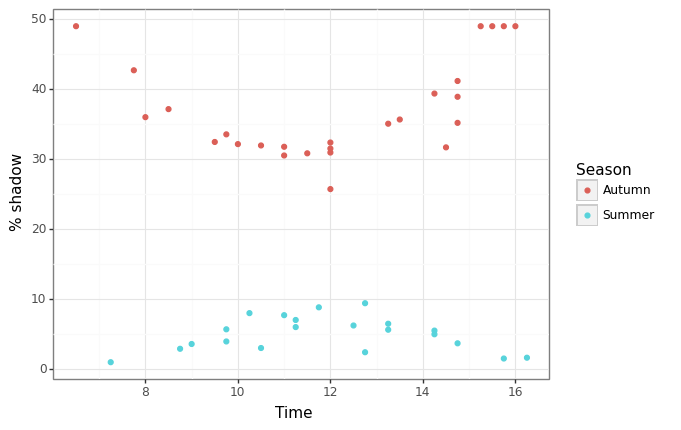

<ggplot: (110886828816)>


In [23]:
# Just show raw data for diagnostics

graph_df = perc_df.copy()
graph_df['time'] = pd.to_datetime(graph_df['time'], format='%H:%M')
graph_df['time'] = graph_df['time'].dt.strftime('%H').astype(float) + graph_df['time'].dt.strftime('%M').astype(float)/60


plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='time', y='shadow', colour='Season'))
plt = plt + labs(x='Time', y='% shadow')
plt = plt + theme_bw()
print(plt)

In [24]:
# Middle of campaign (of data available from the drone)
#--------------------

# Create DOY column
def create_middle_doy(temp, timestamp_col, group_cols):
    temp = temp.copy()
    temp['doy'] = temp[timestamp_col].dt.strftime('%j').astype(float)
    # Calculate middle
    out_df = temp[group_cols + ['doy']].groupby(group_cols).agg(['min','max'])
    out_df.reset_index(inplace=True)
    out_df.columns = ['_'.join(col).strip('_') for col in out_df.columns.values]
    out_df['doy'] = np.round((out_df['doy_min'] + out_df['doy_max'])/2, 0)
    # Cleanup
    out_df.drop(['doy_min', 'doy_max'], axis=1, inplace=True)
    return(out_df)

#doy_df = create_middle_doy(perc_df, 'DateTime', ['Ecosystem', 'Season'])
#display(doy_df)

In [25]:
def create_15min_diurnal_df(temp, timestamp_col, group_cols):
    temp = temp.copy()
    # Collapse percentages to diurnals
    temp['DateTime2'] = pd.to_datetime(temp['time'], format='%H:%M')

    # set the DateTime column as the index
    temp.set_index('DateTime2', inplace=True)
    # resample the data to 15-minute intervals and apply a smoothing function (e.g., rolling mean)
    out_df = temp.sort_values(by=['time']).groupby(group_cols).rolling(window=6, min_periods=2).mean()
    out_df.reset_index(inplace=True)
    out_df.rename({'DateTime2': 'DateTime'}, axis=1, inplace=True)
    out_df['time'] = out_df['DateTime'].dt.strftime('%H:%M')
    col = out_df.pop('time')
    out_df.insert(0, col.name, col, allow_duplicates=True)
    out_df.drop(['DateTime'], axis=1, inplace=True)
    
    # Add repr DOY for this
    doy_df = create_middle_doy(perc_df, timestamp_col, group_cols)
    out_df = out_df.merge(doy_df, on=group_cols, how='left')
    return(out_df)

df_resampled = create_15min_diurnal_df(perc_df, 'DateTime', ['Ecosystem', 'Season'])

#display(df_resampled.loc[~df_resampled['shadow'].isna()])

C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


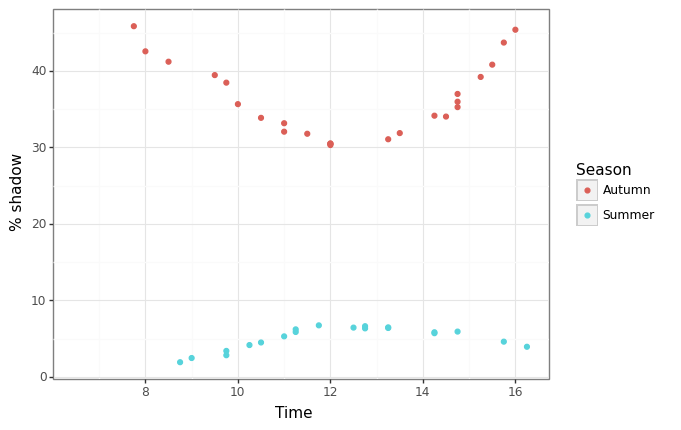

<ggplot: (110886827180)>


In [26]:
# Show data again for diagnostics

graph_df = df_resampled.copy()
graph_df['time'] = pd.to_datetime(graph_df['time'], format='%H:%M')
graph_df['time'] = graph_df['time'].dt.strftime('%H').astype(float) + graph_df['time'].dt.strftime('%M').astype(float)/60


plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='time', y='shadow', colour='Season'))
plt = plt + labs(x='Time', y='% shadow')
plt = plt + theme_bw()
print(plt)

In [27]:
def convert_time_to_decimal(time_data):
    # Convert time
    time_data = pd.to_datetime(time_data, format='%H:%M')
    time_decimal = time_data.dt.strftime('%H').astype(float) + time_data.dt.strftime('%M').astype(float)/60
    return(time_decimal)

# fit cosine curve
def fit_daily_cos_curve(temp):
    temp = temp.copy()
    # Convert time
    temp['time'] = convert_time_to_decimal(temp['time'])

    # Keep only data without NAs
    temp = temp.loc[~temp['shadow'].isna()].copy()

    # Define data for curve fitting
    x_data = temp['time']
    y_data = temp['shadow']

    def shadow_cosine(hour, a, b, c, d):
        return a * np.cos(np.radians(hour+b)) + d
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        param, _ = curve_fit(shadow_cosine, x_data, y_data)
    
    return(param)

def shadow_daily(hour, a, b, c, d):
    return a * np.cos(np.radians(hour+b)) + d

# Run for the entire dataset
#---------------------------
parameters = []
# Iterate over the seasons to fit curves
for current_season in df_resampled['Season'].unique():
    current_doy = df_resampled.loc[df_resampled['Season'] == current_season, 'doy'].unique()[0]
    # Fit the curve
    param = fit_daily_cos_curve(df_resampled.loc[df_resampled['Season'] == current_season])
    param = [current_season, current_doy] + list(param)
    parameters.append(param)
    pass
param_df = pd.DataFrame(parameters, columns = ['Season', 'doy', 'a', 'b', 'c', 'd'])
display(param_df)

,Season,doy,a,b,c,d
0,Autumn,300.0,-5426.645857,1427.885284,1.0,5457.687125
1,Summer,201.0,1731.603368,-13.055358,1.0,-1725.099441


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 28 rows containing missing values.
C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


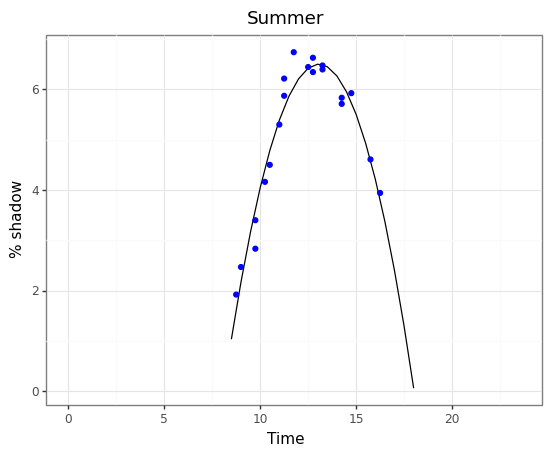

<ggplot: (110886538162)>


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


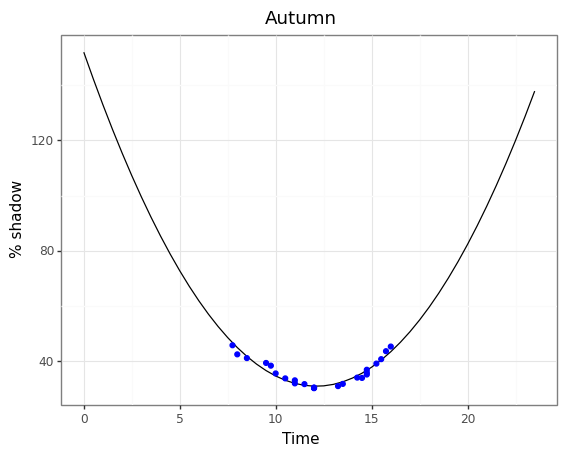

<ggplot: (110886542430)>


In [28]:
# Plot for diagnostics: Summer
#-----------------------------

params = param_df.loc[param_df['Season'] == 'Summer']

# Raw data to be shown in the plot
x_data = convert_time_to_decimal(df_resampled.loc[df_resampled['Season'] == 'Summer', 'time'])
y_data = df_resampled.loc[df_resampled['Season'] == 'Summer', 'shadow']

# Model data
x_data_model = np.arange(0,24, 0.5)
y_data_model = shadow_daily(x_data_model, params['a'].values[0], params['b'].values[0], params['c'].values[0], params['d'].values[0])
y_data_model = np.where(y_data_model > 0, y_data_model, np.nan)

# Plot
plt = ggplot()
plt = plt + geom_line(aes(x=x_data_model, y=y_data_model))
plt = plt + geom_point(aes(x=x_data, y=y_data), colour='blue')
plt = plt + labs(x='Time', y='% shadow')
plt = plt + ggtitle('Summer')
plt = plt + theme_bw()
print(plt)

# Plot for diagnostics: Autumn
#-----------------------------

params = param_df.loc[param_df['Season'] == 'Autumn']

# Raw data to be shown in the plot
x_data = convert_time_to_decimal(df_resampled.loc[df_resampled['Season'] == 'Autumn', 'time'])
y_data = df_resampled.loc[df_resampled['Season'] == 'Autumn', 'shadow']

# Model data
x_data_model = np.arange(0,24, 0.5)
y_data_model = shadow_daily(x_data_model, params['a'].values[0], params['b'].values[0], params['c'].values[0], params['d'].values[0])
y_data_model = np.where(y_data_model > 0, y_data_model, np.nan)

# Plot
plt = ggplot()
plt = plt + geom_line(aes(x=x_data_model, y=y_data_model))
plt = plt + geom_point(aes(x=x_data, y=y_data), colour='blue')
plt = plt + labs(x='Time', y='% shadow')
plt = plt + ggtitle('Autumn')
plt = plt + theme_bw()
print(plt)

In [29]:
# Create new df with some times of day for seasonal fitting
#----------------------------------------------------------
from itertools import product

# Prepare dataframe
seasons = ['Summer', 'Autumn']
times = np.arange(0, 24, 0.25)
cols = list(product(seasons, times))
t_df = pd.DataFrame(cols, columns=['Season','time'])

# Fill with necessary information
t_df['doy'] = np.nan
t_df['shadow'] = np.nan
shadow_perc = []
for current_season in t_df['Season'].unique():
    current_doy = df_resampled.loc[df_resampled['Season'] == current_season, 'doy'].unique()[0]
    params = param_df.loc[param_df['Season'] == current_season]
    # Fit the curve
    shadow_perc = list(shadow_daily(t_df.loc[t_df['Season'] == current_season, 'time'],
                                              params['a'].values[0], params['b'].values[0], params['c'].values[0], params['d'].values[0]))
    t_df.loc[t_df['Season'] == current_season, 'doy'] = current_doy
    t_df.loc[t_df['Season'] == current_season, 'shadow'] = shadow_perc
    pass

display(t_df)

,Season,time,doy,shadow
0,Summer,0.00,201.0,-38.254097
1,Summer,0.25,201.0,-36.563420
2,Summer,0.50,201.0,-34.904890
3,Summer,0.75,201.0,-33.278540
4,Summer,1.00,201.0,-31.684398
...,...,...,...,...
187,Autumn,22.75,300.0,124.260827
188,Autumn,23.00,300.0,128.681554
189,Autumn,23.25,300.0,133.203738
190,Autumn,23.50,300.0,137.827292


In [30]:
# Fit annual cosine curve
#-------------------------
def fit_annual_cos_curve(temp):
    temp = temp.copy()
    
    # The highest sun elevation (smallest shadow, summer solstice) is on the 21st of June
    # The lowest sun elevation (largest shadow, winter solstice) is on the 22st of December
    doy_summer_solstice = pd.Series(pd.to_datetime('2019-06-21', format='%Y-%m-%d')).dt.strftime('%j').astype(float).values[0]
    doy_winter_solstice = pd.Series(pd.to_datetime('2019-12-22', format='%Y-%m-%d')).dt.strftime('%j').astype(float).values[0]

    # Fit a cosine curve. The offset of the highest and lowest point of the sun from the end and middle of the year is:
    offset = np.mean([365/2-doy_summer_solstice, 365-doy_winter_solstice])

    # Define x and y data for curve fitting
    x_data = list(temp['doy'])
    y_data = list(temp['shadow'])

    # Define a cosine-based function with two parameters
    # a and b represent the amplitude, and phase shift, respectively.
    def shadow_perc_from_doy(doy, a, c):
        return a * np.cos(np.radians((doy-365/2+offset)*360/364)) + c

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        param, _ = curve_fit(shadow_perc_from_doy, x_data, y_data)
    
    return(list(param) + [offset])


# Prepare a df to fill for each 15min period, with the fit parameters for the shade percentage as a function of doy
doy_list = []
for current_time in t_df['time'].unique():
    # Fit the curve
    params = fit_annual_cos_curve(t_df.loc[t_df['time'] == current_time])
    doy_list.append([current_time] + list(params))
    pass
doy_df = pd.DataFrame(doy_list, columns = ['time', 'a', 'c', 'offset'])
#display(doy_df)

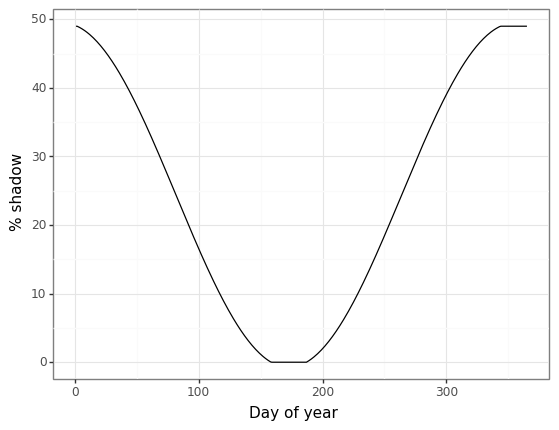

<ggplot: (110886529940)>


In [31]:
# re-define shade function, to apply
def shadow_perc_from_doy(doy, a, c, pv_percent, offset=9.75):
    shadow_perc = a * np.cos(np.radians((doy-365/2+offset)*360/364)) + c
    # Correction for 0% shade, or complete shade
    shadow_perc = np.where(shadow_perc < 0, 0, shadow_perc)
    shadow_perc = np.where(shadow_perc > (100-pv_percent), (100-pv_percent), shadow_perc)
    return shadow_perc

# Fill the entire year's worth of shadow %
#-----------------------------------------
from itertools import product

# Prepare dataframe
doy  = np.arange(1,366)
time = t_df['time'].unique()
cols = list(product(doy, time))
percentage_df = pd.DataFrame(cols, columns=['doy','time'])

# Fill with necessary information
percentage_df = percentage_df.merge(doy_df, on='time', how='left')
percentage_df['shadow'] = shadow_perc_from_doy(percentage_df['doy'], percentage_df['a'], percentage_df['c'], pv_percent)
# Cleanup
percentage_df.drop(['a', 'c', 'offset'], axis=1, inplace=True)

# Fill in panel and soil
#-----------------------
percentage_df['panel'] = pv_percent
percentage_df['soil'] = 100 - percentage_df['panel'] - percentage_df['shadow']

# Check
#display(percentage_df)

plt = ggplot(percentage_df.loc[percentage_df['time'] == 9.00])
plt = plt + geom_line(aes(x='doy', y='shadow'))
plt = plt + labs(x='Day of year', y='% shadow')
plt = plt + theme_bw()
print(plt)

In [32]:
# Save data
def save_percentage_data(fn, temp):
    temp = temp.copy()
    # Convert times back to normal format
    temp['time'] = temp['time'].apply(lambda x: '{:02.0f}:{:02.0f}'.format(*divmod(x * 60, 60)))
    temp.to_csv(output_path + 'PV_percentages_modelled.csv', index=False)
    pass

save_percentage_data(output_path + 'PV_percentages_modelled.csv', percentage_df)

## Calculate albedo

1. Extract the soil albedo from the desert, as diurnals
2. Obtain the diffuse fraction from the Yatir data

In [66]:
def get_diurnal_soil_albedo(temp):
    temp = temp.copy()

    # Fix bad SW values
    temp.loc[temp['SW_IN_merge'] < 1, 'SW_IN_merge'] = 0
    temp.loc[temp['SW_OUT_merge'] < 1, 'SW_OUT_merge'] = 0
    temp.loc[temp['SW_IN_merge'] < 1, 'SW_OUT_merge'] = 0
    temp.loc[temp['PARin'] <= 0, 'SW_IN_merge'] = 0
    temp.loc[temp['PARin'] <= 0, 'SW_OUT_merge'] = 0
    temp.loc[temp['PARout'] <= 0, 'SW_IN_merge'] = 0
    temp.loc[temp['PARout'] <= 0, 'SW_OUT_merge'] = 0

    # Re-calculate albedo from SW measurements (relevant for the desert)
    temp['albedo'] = np.nan
    temp['albedo'] = temp['SW_OUT_merge'] / temp['SW_IN_merge']

    # Extract desert albedo & rename. This will be used for the soil & shade fractions of the PV field
    desert_albedo = temp.loc[temp['Ecosystem'] == 'Desert background',['time','Season','albedo']].copy()
    desert_albedo.rename({'albedo': 'albedo_soil'}, axis=1, inplace=True)

    # Collapse to diurnals
    desert_albedo = desert_albedo.groupby(['time', 'Season']).mean()
    desert_albedo.reset_index(inplace = True)
    
    return(desert_albedo)

def get_diffuse_data(fn, silent=False):
    if not silent: print('Loading diffuse radiation data (from Yatir site):')

    # Yatir dataset, used for diffuse fraction
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yatir_full_df = load_tower(fn) # Load 20 years
    yatir_df = yatir_full_df.loc[(yatir_full_df['DateTime'].dt.year == 2018) | (yatir_full_df['DateTime'].dt.year == 2019)].copy()
    del [yatir_full_df] # Clean up memory
    
    if not silent: print('Done loading data...')
    if not silent: print('Calculate and return diffuse radiation for 2018-2019...')
    
    # Calculate diffuse fraction in Yatir (Assuming it's the same in Ketura)
    yatir_df['f_dif'] = yatir_df['S_top_diff(CM21_V)_Wm-2'] / yatir_df['S_top_atm(CM21_IV)_Wm-2']
    
    return(yatir_df[['DateTime','f_dif']])

def interpolate_val(temp):
    temp = temp.copy()
    
    temp['time'] = temp['DateTime'].dt.strftime('%H:%M')
    
    for t in temp['time'].unique():
        temp.loc[temp['time'] == t, 'f_dif'] = temp.loc[temp['time'] == t, 'f_dif'].rolling(window=14, min_periods=1).mean() #interpolate(limit = 5)
        
    temp.drop(['time'], axis=1, inplace=True)
    return(temp)

In [67]:
# Obtain desert soil albedo
desert_albedo = get_diurnal_soil_albedo(ketura_df)

# Get diffuse radiation from Yatir (slow)
dif_df = get_diffuse_data(yatir_fn)

# Make rolling means interpolating the diffuse radiation
dif_df = interpolate_val(dif_df)
    
# Extract measurement times in the PV field
pv_albedo = ketura_df.loc[ketura_df['Ecosystem'] == 'PV field',['DateTime','time','Season','SW_IN_merge']].copy()
# Add day-of-year
pv_albedo['doy'] = pv_albedo['DateTime'].dt.strftime('%j').astype(int)

# Add percentages
percentages = percentage_df.copy()
percentages['time'] = percentages['time'].apply(lambda x: '{:02.0f}:{:02.0f}'.format(*divmod(x * 60, 60)))
pv_albedo = pv_albedo.merge(percentages, on=['doy','time'], how='left')

# Add diffuse fraction
pv_albedo = pv_albedo.merge(dif_df, on=['DateTime'], how='left')

# Add soil albedo
pv_albedo = pv_albedo.merge(desert_albedo, on=['Season','time'], how='left')

# Calculate shade albedo
pv_albedo['albedo_shade'] = pv_albedo['albedo_soil'] * pv_albedo['f_dif']

# Calculate PV field albedo based on percentages
pv_albedo['albedo'] = pv_albedo['albedo_soil'] * pv_albedo['soil'] \
                    + pv_albedo['albedo_shade'] * pv_albedo['shadow'] \
                    + albedo_pv * pv_albedo['panel']

# Save data
pv_albedo.to_csv(output_path + 'PV_albedo_campaigns_modelled.csv', index=False)

# Show some example data
display(pv_albedo.loc[pv_albedo['time'] == '12:15'])

Loading diffuse radiation data (from Yatir site):
  - Yatir_2000-2020.csv (Note: slow)
Done loading data...
Calculate and return diffuse radiation for 2018-2019...


,DateTime,time,Season,SW_IN_merge,doy,shadow,panel,soil,f_dif,albedo_soil,albedo_shade,albedo
24,2019-07-15 12:15:00,12:15,Summer,1034.850,196,5.708524,51,43.291476,0.120515,0.369113,0.044484,18.783371
60,2018-03-21 12:15:00,12:15,Spring,962.693,80,21.708309,51,27.291691,0.217750,0.395457,0.086111,15.212021
108,2018-10-23 12:15:00,12:15,Autumn,692.844,296,30.091853,51,18.908147,0.373390,0.377924,0.141113,13.942186
155,2019-07-18 12:15:00,12:15,Summer,968.407,199,6.069570,51,42.930430,0.153732,0.369113,0.056745,18.740583
203,2019-07-19 12:15:00,12:15,Summer,1023.800,200,6.198984,51,42.801016,0.154631,0.369113,0.057076,18.702214
251,2019-07-20 12:15:00,12:15,Summer,1016.660,201,6.332868,51,42.667132,0.155381,0.369113,0.057353,18.662192
299,2019-07-21 12:15:00,12:15,Summer,1015.770,202,6.471181,51,42.528819,0.149182,0.369113,0.055065,18.604263
347,2019-07-22 12:15:00,12:15,Summer,999.330,203,6.613883,51,42.386117,0.147699,0.369113,0.054518,18.555828
395,2019-07-23 12:15:00,12:15,Summer,998.724,204,6.760931,51,42.239069,0.147470,0.369113,0.054433,18.508996
442,2018-03-23 12:15:00,12:15,Spring,772.533,82,21.127410,51,27.872590,0.233345,0.395457,0.092278,15.522012


In [68]:
def weighted_avg_and_std(values, weights):
    values = np.ma.masked_invalid(values)
    # Return the weighted average and standard deviation.
    average = np.ma.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.ma.average((values-average)**2, weights=weights)
    
    maximum = np.max(values)
    minimum = np.min(values)
    return (average, np.sqrt(variance), maximum, minimum)

print('Spring:')
spring = pv_albedo.loc[pv_albedo['Season'] == 'Spring']
print(weighted_avg_and_std(spring['albedo'], spring['SW_IN_merge']))
print()

print('Summer:')
summer = pv_albedo.loc[pv_albedo['Season'] == 'Summer']
print(weighted_avg_and_std(summer['albedo'], summer['SW_IN_merge']))
print()

print('Autumn:')
autumn = pv_albedo.loc[pv_albedo['Season'] == 'Autumn']
print(weighted_avg_and_std(autumn['albedo'], autumn['SW_IN_merge']))

Spring:
(15.490505715866423, 0.7040315321994572, 23.517264660257272, 14.779093977274387)

Summer:
(19.58075660347228, 1.1658730879519243, 37.39489408564174, 18.50899583795556)

Autumn:
(13.484389507052397, 1.1601960706924463, 24.485656301642944, 2.5500000000000003)


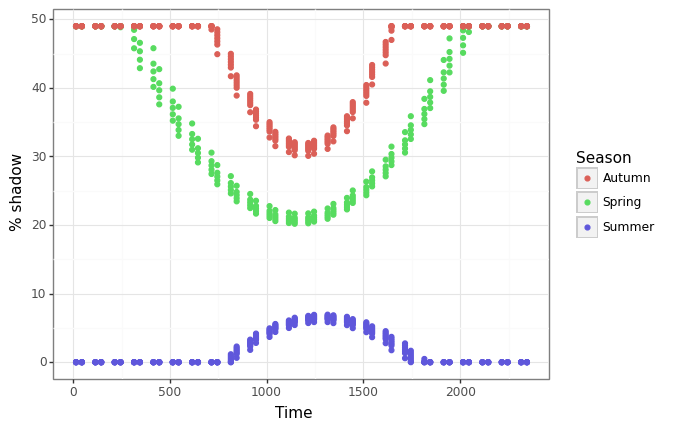

<ggplot: (110887282300)>


In [69]:
graph_df = pv_albedo.copy()
graph_df['time'] = graph_df['DateTime'].dt.strftime('%H%M').astype(int)

plt = ggplot(graph_df)
plt = plt + geom_point(aes(x='time', y='shadow', colour = 'Season'))
plt = plt + labs(x='Time', y='% shadow')
plt = plt + theme_bw()
print(plt)